### This code illustrates how to compute mean square displacement for a single $CO_{2}$ molecule in a given trajectory

### Package Required:
* numpy
* mdtraj

#### Note: If you don't have the packages listed above installed, then you can type in the following commands in the terminal
* conda install numpy
* conda install -c conda-forge mdtraj


### File Required:
* A trajectory file (.h5)

* Note: Here, I use a trajectory that contains only one CO2 molecule as an example (~/pikachu/homes/zhuo/haverford/code_example/BMIM_PF6_CO2_system_eq_step4.h5), but this code can also be used for systems with multiple CO2 molecules.

### Background:

* Periodic boundary condition (PBC)
In simulation, we usually use a small unit cell to represent a large system using periodic boundary condition. However, if the particle move through one side of the unit cell, it will show up on the opposite side of the unit cell under PBC. See the following image for illustration.  

 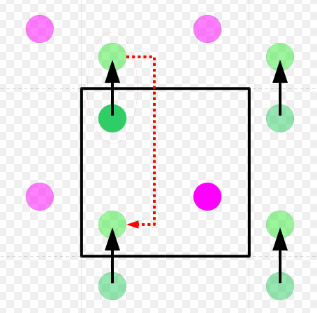

In that case, we will need to consider PBC when doing calculation that involves the position vector of the pariticle. For example, in a 10 x 10 square system, if a particle is moving from (1,1) to (-1,-1), then it will show up at (9,9) instead of (1,1) then. So, in order to implement PBC when calculating the vector or distance between the point gets across the boundary. The following expression is used:

Vector (x0 --> x1) 

$$ 
Vector =
\begin{cases} 
    x_{1} - x_{0} - L_{x} & \text{if } x_{1} - x_{0} \geq 0.5L_{x} \\
    x_{1} - x_{0} & \text{if } -0.5L_{x} < x_{1} - x_{0} < 0.5L_{x} \\
    L_{x}- x_{1} + x_{0} & \text{if } x_{1} - x_{0} \leq -0.5L_{x}  \\
\end{cases}
$$

* Source: https://en.wikipedia.org/wiki/Periodic_boundary_conditions

* Time separation ($\tau$)

The picture below is from Logan's Thesis Figure 12

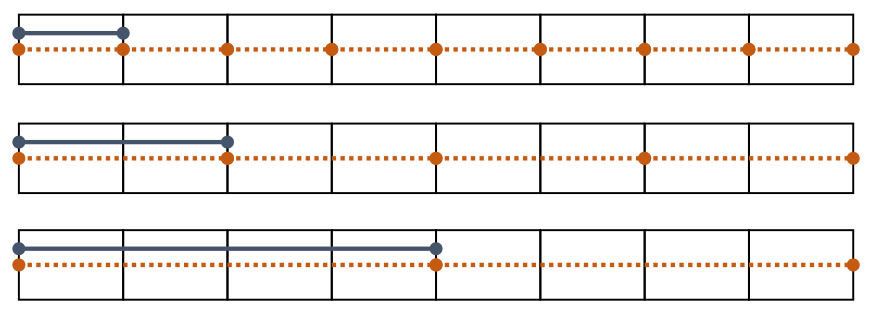

Suppose the total time length is 8 s (the orange dotted line), then the $\tau$ is 1 s, 2 s, and 4 s (the blue solid line) from the top to bottom in this figure.


* Mean square displacement (MSD)

Typically, MSD is used to calculate the diffusion coefficient which predicts the mobility of the particle or its dynamic property.  

### Equation: 

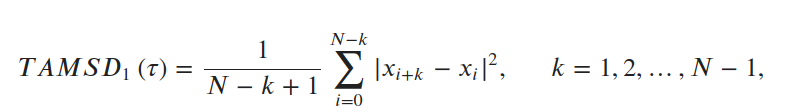

where N is the number of frames, x is the xyz coordinates, and $\tau$ = k$\Delta t$ ($\Delta t$ is the timestep)

Check out the example below for a simple MSD calculation. If you want to know more about MSD, here is the resource: [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8687545/ 

### Example for MSD calculation:

Suppose we have only 1 CO2 molecule in the trajectory that has 6 frames (total simulation time is 5 ns) and the timestep is set to be 1 ns.

For $\tau$ = 0, we have MSD(0) = 0 since the molecule is not moving at all within the same frame.

For $\tau$ = 1 ns, we have MSD(1) = $\frac{1}{5-1+1}$($|x_{5}-x_{4}|^{2}$+$|x_{4}-x_{3}|^{2}$+$|x_{3}-x_{2}|^{2}$+$|x_{2}-x_{1}|^{2}$+$|x_{1}-x_{0}|^{2}$)

For $\tau$ = 2 ns, we have MSD(2) = $\frac{1}{5-2+1}$($|x_{5}-x_{3}|^{2}$+$|x_{4}-x_{2}|^{2}$+$|x_{3}-x_{1}|^{2}$+$|x_{2}-x_{0}|^{2}$)

For $\tau$ = 5 ns, we have MSD(5) = $\frac{1}{5-5+1}$($|x_{5}-x_{0}|^{2}$

If we have more than 1 CO2 in a snapshot, we will need to use the average/mean of the sum of the distance square, aka $<|x_{i+k}-x_{i}|^{2}>$ instead of $|x_{i+k}-x_{i}|^{2}$

### The Actual Code:

1. Import the required package

In [22]:
import numpy as np
import mdtraj as md
import math

2. Load the trajectory file 

In [23]:
traj = md.load_hdf5('BMIM_PF6_CO2_system_eq_step4.h5')
traj

<mdtraj.Trajectory with 10000 frames, 12550 atoms, 513 residues, and unitcells at 0x7f6dcabe2e10>

3. Extract some basic information from the trajectory

In [24]:
box_sizes = traj.unitcell_lengths[0]
box_sizes

array([4.4480777, 4.4480777, 4.4480777], dtype=float32)

In [25]:
n_frames = traj.n_frames
n_frames

10000

In [26]:
n_atoms = traj.n_atoms
n_atoms

12550

In [27]:
timestep = traj.timestep/1000 # convert ps into ns here
timestep

0.01

4. Extract the xyz coordinates for the given atom (e.g. C) 

In [28]:
carbon = traj.topology.select('name == C') # here, we extract the atom_index for the carbon atom in the snapshot 
carbon

array([0])

In [29]:
xyz_carbon = traj.xyz[:,carbon,:] # traj.xyz[frame_id,atom_index,xyz_coordinates]
# Here, we extract all the xyz coordinates for the carbon atoms throughout all the frames 
xyz_carbon

array([[[0.5326969, 0.5994113, 2.7604756]],

       [[0.5366426, 0.6764617, 2.7344258]],

       [[0.6820233, 0.5732599, 2.8127644]],

       ...,

       [[1.5890062, 3.9633927, 3.207243 ]],

       [[1.5668223, 3.9849327, 3.149382 ]],

       [[1.6794393, 4.078516 , 3.2362943]]], dtype=float32)

5. Set up the time separation, $\tau$. 

In [30]:
taus = np.linspace(0,(n_frames-1)*timestep,n_frames) # The minimum tau value is set to be the same as the timestep
taus

array([0.000e+00, 1.000e-02, 2.000e-02, ..., 9.997e+01, 9.998e+01,
       9.999e+01])

In [31]:
def vector_pbc(x0,x1,Box):
    """
    calculate vector with periodic boundary condition

    x0 -- initial position
    x1 -- finial position
    Box -- box size
    everyhing is in 1D, but can be used to calculate multiple dimensions as well
    """

    delta = x1 - x0
    delta= np.where(np.abs(delta) > 0.5 * Box, np.where(delta > 0, np.abs(delta)-Box,Box-np.abs(delta)), delta)
    return delta

def dist_pbc(x0,x1,Box):
    return np.sqrt(np.sum(vector_pbc(x0,x1,Box)**2.0, axis = -1))

6. Now, we are about to calculate the MSD
#### Note: We are tracking the movement of the carbon atom to approximate the movement of a CO2 molecule in this code example here

#### Optional: Going back to the example we have for 6 frames and 1 CO2 

In [ ]:
n_frames = 6
taus = np.linspace(0,(n_frames-1)*timestep,n_frames) # The minimum tau value is the timestep
msds = []
xyz = xyz_carbon
start_frame = 0
end_frame = n_frames

for i in range(0,n_frames):
    dists_square = []
    dists_square_pbc = []
    xyz1 = xyz[np.arange(start_frame,end_frame-i),:,:]
    xyz2 = xyz[np.arange(start_frame+i,end_frame),:,:]
    dists_square.append(dist_pbc(xyz1,xyz2,box_sizes)**2) # This allows us to calculate the distance square between every i frames.
    print(dists_square)
    print()
    msds.append(np.mean(dists_square))  # Average the distance square 

The actual code for all the frames in the trajectory

In [41]:
n_frames = traj.n_frames
taus = np.linspace(0,(n_frames-1)*timestep,n_frames) # The minimum tau value is the timestep
msds = []
xyz = xyz_carbon
start_frame = 0
end_frame = n_frames

for i in range(0,n_frames):
    dists_square = []
    dists_square_pbc = []
    xyz1 = xyz[np.arange(start_frame,end_frame-i),:,:]
    xyz2 = xyz[np.arange(start_frame+i,end_frame),:,:]
    dists_square.append(dist_pbc(xyz1,xyz2,box_sizes)**2) # This allows us to calculate the distance square between every i frames.
    msds.append(np.mean(dists_square))  # Average the distance square 
print(msds)

[0.0, 0.04456599, 0.05739913, 0.06776607, 0.07667324, 0.084502935, 0.09311528, 0.10171908, 0.1086934, 0.115541376, 0.12303176, 0.13008174, 0.13673921, 0.14311945, 0.14966561, 0.1563268, 0.16292179, 0.16914655, 0.17535165, 0.18166952, 0.18824802, 0.19382572, 0.20026556, 0.20595385, 0.21260545, 0.2184489, 0.22488223, 0.23132321, 0.23713985, 0.24303459, 0.24883522, 0.25452265, 0.25967467, 0.2654786, 0.27095845, 0.27642873, 0.28235933, 0.28825805, 0.293093, 0.2986361, 0.30372146, 0.3091389, 0.31431857, 0.32008177, 0.3251353, 0.33068478, 0.3353902, 0.3410573, 0.3460701, 0.35116965, 0.35660982, 0.36193684, 0.36776158, 0.37335554, 0.37853566, 0.38337365, 0.38953388, 0.3945969, 0.40021306, 0.4056747, 0.41074783, 0.41621065, 0.4218801, 0.42721188, 0.4328997, 0.43865183, 0.444068, 0.44989535, 0.45579645, 0.46169275, 0.46740335, 0.47254413, 0.47779486, 0.4833434, 0.48869997, 0.49364948, 0.4987642, 0.5036341, 0.5087198, 0.51408166, 0.5200718, 0.5255034, 0.5307355, 0.5358785, 0.54072374, 0.5466724,

7. Save the data to a .txt file

In [42]:
np.savetxt('BMIM_PF6_CO2_system_eq_step4_msd.txt',np.c_[taus,msds],fmt ='%.6f',delimiter =',',header='taus[ns],msds[nm^2]')

8. Done! 

Now, we have the data for the time separation and MSD to calculate the diffusion coefficient. To do that, check out the next code example 'Diffusion_coefficient_calculation'